# Set Up

#### Utilities

In [74]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

#### Modeling Tools

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# EDA

## Basic Data Set Verification

### Engagement Df

In [76]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')

In [77]:
engagement_df.shape

(207917, 3)

In [78]:
engagement_df.head(3)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1


### User DF

In [79]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [80]:
users_df.shape

(12000, 10)

In [81]:
users_df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [82]:
users_df.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0


I think object_id is user id, but I wanted to see if it conformed to my expectations for that column, and it did.

In [83]:
users_df.object_id.value_counts()

2049     1
10912    1
661      1
6806     1
4759     1
        ..
7481     1
1338     1
3387     1
9534     1
2047     1
Name: object_id, Length: 12000, dtype: int64

**Internal Problem Statement**: 

Okay, so we want to make a column in the users df, that lists the number of unique visits for each user. Unique visits are entries in the engagement df.

Curious about the number of visits for this visitor in particular

## Exploration of # of visits

In [84]:
engagement_df[engagement_df.user_id == 2]

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1


Some of these users have logged in a whole heck of a lot of times

In [85]:
engagement_df.user_id.value_counts(sort=True, ascending=False).head(20)

3623    606
906     600
1811    593
7590    590
8068    585
9402    581
4022    580
3269    566
9312    547
7210    545
8029    541
2474    538
2658    526
8280    521
69      521
5297    520
4019    519
9083    517
2519    511
4263    509
Name: user_id, dtype: int64

In [86]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [87]:
users_df.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


# Feature Engineering

## Manufacture of 'adopted' column

Just counting how many visits each user has

In [88]:
In [36]: engagement_df.groupby(["user_id"]).count().sort_values(["visited"], ascending=False)

,time_stamp,visited
user_id,,
3623,606,606
906,600,600
1811,593,593
7590,590,590
8068,585,585
...,...,...
4699,1,1
4698,1,1
4697,1,1


In [89]:
user_visits = engagement_df.groupby(["user_id"]).count()

In [90]:
user_visits.head(3)

,time_stamp,visited
user_id,,
1,1,1
2,14,14
3,1,1


Messing with index values is less comfortable for me than interacting with columns, so i'm just gonna pull out the index on this dataframe

In [91]:
user_visits = user_visits.reset_index()

This column is completely useless in this new counting frame, so we're removing it.

In [92]:
user_visits = user_visits.drop(columns=['time_stamp'])

Just checking that thigns look right. I know that user 2 had a bunch of visits, but the other first five had one. So this makes sense so far.

In [93]:
user_visits.head(5)

,user_id,visited
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


### Visit Counter Function

Curious about the distribution of number of visits. Looks like over half of our users only visited once.

In [94]:
user_visits.visited.value_counts().head(25)

1     6235
2      340
3      241
4      181
5      110
6       85
7       68
8       57
9       48
10      34
14      30
13      29
12      29
11      26
22      23
16      20
25      19
17      18
23      18
18      18
20      16
24      15
26      15
21      15
27      13
Name: visited, dtype: int64

This was a naive attempt to answer the immediete question of who had three vistis. I hadn't yet realized they needed to be within a week of eachother.

In [95]:
def count_adder(value):
    visit_count = 0
    try:
        visit_count = int(user_visits.loc[user_visits['user_id'] == value].visited)
    except TypeError:
        return 0
    if visit_count >= 3:
        return 1
    return 0
    
    
    
    

In [96]:
engagement_df['atemp_adopted_user'] = engagement_df.user_id.apply(count_adder)

This worked, but now we need to bring in the temporal constraint.

In [97]:
adoptee_df = engagement_df[engagement_df.atemp_adopted_user > 0]

In [98]:
print(adoptee_df.shape)
adoptee_df.head(10)

(201002, 4)


,time_stamp,user_id,visited,atemp_adopted_user
1,2013-11-15 03:45:04,2,1,1
2,2013-11-29 03:45:04,2,1,1
3,2013-12-09 03:45:04,2,1,1
4,2013-12-25 03:45:04,2,1,1
5,2013-12-31 03:45:04,2,1,1
6,2014-01-08 03:45:04,2,1,1
7,2014-02-03 03:45:04,2,1,1
8,2014-02-08 03:45:04,2,1,1
9,2014-02-09 03:45:04,2,1,1
10,2014-02-13 03:45:04,2,1,1


In [99]:
len(adoptee_df.user_id.unique())

2248

In [100]:
len(engagement_df.user_id.unique())

8823

### This is where we start exploring the timestamp tomfoolery to temporalize our adoption measure

In [101]:
adoptee_df['datetime'] = pd.to_datetime(adoptee_df['time_stamp'])

<ipython-input-101-55e2eb7751f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adoptee_df['datetime'] = pd.to_datetime(adoptee_df['time_stamp'])


Making a dictionary of all the users with atemporal adoption

In [102]:
potential_dict = {}
for each in adoptee_df.user_id.unique():
    potential_dict[each] = []

Adding in the visit times for the users above

In [103]:
for key in potential_dict.keys():
    for each in adoptee_df.datetime[engagement_df.user_id == key]:
        potential_dict[key].append(each)

### Function to take the atemporal adoptors and narrow them down to adopters who passed the 3 visits within one consecutive week threshold

In [104]:
def adoption_checker(listo):
    delta = datetime.timedelta(days=7)
    zero_point = datetime.timedelta(days=0)
    
    for each in listo:
        consecutive_list = []
        consecutive_list.append(each)

        for second_each in listo:
            subtraction = second_each - consecutive_list[0]
            
            if subtraction < delta and subtraction > zero_point:
                consecutive_list.append(second_each)
                
                if len(consecutive_list) >= 3:
                    return 1
                
            elif second_each - consecutive_list[0] > delta: 
                break
        
                
    return False
            
            
    

In [105]:
actual_adoptees = {}
for key, value in potential_dict.items():
    actual_adoptees[key] =  adoption_checker(value)
    

Converting the dictionary we just made into a dataframe

In [106]:
adoption_df = pd.DataFrame([actual_adoptees]).transpose().reset_index()

In [107]:
adoption_df['user_id'] = adoption_df['index']
adoption_df = adoption_df.drop(columns=['index'])

In [108]:
adoption_df['object_id'] =adoption_df['user_id']
adoption_df['adoption_status'] =adoption_df[0]

In [109]:
adoption_df= adoption_df.drop(columns=[0, 'user_id'])

In [110]:
adoption_df

,object_id,adoption_status
0,2,1
1,10,1
2,20,1
3,33,1
4,42,1
...,...,...
2243,11975,1
2244,11980,False
2245,11981,False
2246,11988,1


Looks like all our transformations paid off

In [111]:
users_df=users_df.merge(adoption_df, on='object_id', how='left') 

In [112]:
users_df.adoption_status.fillna(value=0, inplace=True)

### Adding total number of visits as a feature

In [113]:
#Changing the user column to be the same name as the one in the users_df 
user_visits['object_id'] = user_visits['user_id']
user_visits = user_visits.drop(columns=['user_id'])

In [114]:
#Add in the visit count for each user to the main dataframe
users_df = users_df.merge(user_visits, on=['object_id'], how='left')
#Changing the name of the column, and removing the old one
users_df['visits'] = users_df.visited

users_df.drop(columns='visited', inplace=True)
#Replacing NaNs with 0, as 0 is in fact a number and that's how many visits they had.
users_df.visits.fillna(value=0, inplace=True)

# PreProcessing

### Time Conversions


https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date


It is really important to differentiate the data types that you want to use for regression/classification.

When you are using time series, that is another case but if you want to use time data as a numerical data type as your input, then you should transform your data type from datetime to float (if your data_df['conv_date] is a datetime object, if not then you should first transform it by using; data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D") )

I agree with Thomas Vetterli's answer. It is useful to be careful what kind of time data you are using.

If you are only using year and month data then dt.datetime.toordinal would be enough to use;

>import datetime
>data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D")
>data_df['conv_date'] = data_df['conv_date'].map(datetime.datetime.toordinal)
737577
But if you want to use also the hour, minute and second information then time.mktime() suits better;

>import time
>data_df['conv_date'] = pd.to_datetime(data_df.date, format="%Y-%M-%D")
>data_df['conv_date'] = data_df['conv_date'].apply(lambda  var: time.mktime(var.timetuple()))
1591016041.0 

Also 1591016044.0 is another exemplary output from my data, it varies with changes in seconds.

In [115]:
users_df.creation_time = pd.to_datetime(users_df.creation_time)


In [116]:
users_df['oridinal_creation_date'] = users_df['creation_time'].map(datetime.datetime.toordinal)

### These four columns are all just going to be unique.

    Though maybe some seasonality could be detected in the relationship between creationtime and the adoption status of the account, but given our constricted time I'm going to treat that as out of scope.

In [117]:
users_df.drop(columns=['name', 'email', 'last_session_creation_time'], inplace=True)

In [118]:
users_df.invited_by_user_id.isnull().sum()

5583

In [119]:
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)
users_df.invited_by_user_id.isnull().sum()

0

In [120]:
users_df

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adoption_status,visits,oridinal_creation_date
0,1,GUEST_INVITE,1,0,11,10803.0,0,1.0,735345
1,2,ORG_INVITE,0,0,1,316.0,1,14.0,735187
2,3,ORG_INVITE,0,0,94,1525.0,0,1.0,734946
3,4,GUEST_INVITE,0,0,1,5151.0,0,1.0,735009
4,5,GUEST_INVITE,0,0,193,5240.0,0,1.0,734885
...,...,...,...,...,...,...,...,...,...
11995,11996,ORG_INVITE,0,0,89,8263.0,0,1.0,735117
11996,11997,SIGNUP_GOOGLE_AUTH,0,0,200,0.0,0,1.0,734878
11997,11998,GUEST_INVITE,1,1,83,8074.0,0,1.0,735350
11998,11999,PERSONAL_PROJECTS,0,0,6,0.0,0,1.0,734654


In [121]:
len(users_df.invited_by_user_id.unique())

2565

### One Hot encoding categorical columns

In [133]:
to_dummy =users_df[['creation_source','org_id','invited_by_user_id']]

In [134]:
to_dummy

,creation_source,org_id,invited_by_user_id
0,GUEST_INVITE,11,10803.0
1,ORG_INVITE,1,316.0
2,ORG_INVITE,94,1525.0
3,GUEST_INVITE,1,5151.0
4,GUEST_INVITE,193,5240.0
...,...,...,...
11995,ORG_INVITE,89,8263.0
11996,SIGNUP_GOOGLE_AUTH,200,0.0
11997,GUEST_INVITE,83,8074.0
11998,PERSONAL_PROJECTS,6,0.0


In [138]:
dummy = pd.get_dummies(to_dummy, columns=['creation_source','org_id','invited_by_user_id'],)


In [139]:
dummy.columns

Index(['creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'org_id_0', 'org_id_1',
       'org_id_2', 'org_id_3', 'org_id_4',
       ...
       'invited_by_user_id_11966.0', 'invited_by_user_id_11972.0',
       'invited_by_user_id_11973.0', 'invited_by_user_id_11974.0',
       'invited_by_user_id_11978.0', 'invited_by_user_id_11981.0',
       'invited_by_user_id_11986.0', 'invited_by_user_id_11994.0',
       'invited_by_user_id_11997.0', 'invited_by_user_id_11999.0'],
      dtype='object', length=2987)

In [140]:
dummy

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,org_id_1,org_id_2,org_id_3,org_id_4,...,invited_by_user_id_11966.0,invited_by_user_id_11972.0,invited_by_user_id_11973.0,invited_by_user_id_11974.0,invited_by_user_id_11978.0,invited_by_user_id_11981.0,invited_by_user_id_11986.0,invited_by_user_id_11994.0,invited_by_user_id_11997.0,invited_by_user_id_11999.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [141]:
users_df.drop(columns=['creation_source','org_id','invited_by_user_id', 'object_id'], inplace=True)
users_df = users_df.join(dummy, rsuffix='dummy_')



In [144]:
X = users_df.drop(['adoption_status'], axis=1)
y = users_df['adoption_status']
y=y.astype('int')

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

# Modeling

In [147]:
lr = LogisticRegression()


In [148]:
lr.fit(X_train, y_train)

LogisticRegression()

# Feature Importance Examination

In [149]:
coefficients = lr.coef_

In [150]:
coefficients

array([[ 8.44525585e-05,  9.89322325e-05,  7.75642373e-01, ...,
        -2.59756147e-06, -8.65820046e-07, -4.33024750e-06]])

In [151]:
columns = X_train.columns

In [152]:
coef_df = pd.DataFrame(zip(list(columns),list(coefficients[0])),columns=['feature','coefficient'])

In [153]:
coef_df.sort_values(by='coefficient', ascending=False).head(20)

,feature,coefficient
2,visits,0.775642
4,creation_source_GUEST_INVITE,0.000331
8,creation_source_SIGNUP_GOOGLE_AUTH,0.000248
1,enabled_for_marketing_drip,0.000099
0,opted_in_to_mailing_list,0.000084
227,org_id_218,0.000030
244,org_id_235,0.000030
91,org_id_82,0.000028
53,org_id_44,0.000025
298,org_id_289,0.000025


This barplot is laughable. The only predictive feature in this set without further feature engineering is simply number of visits.

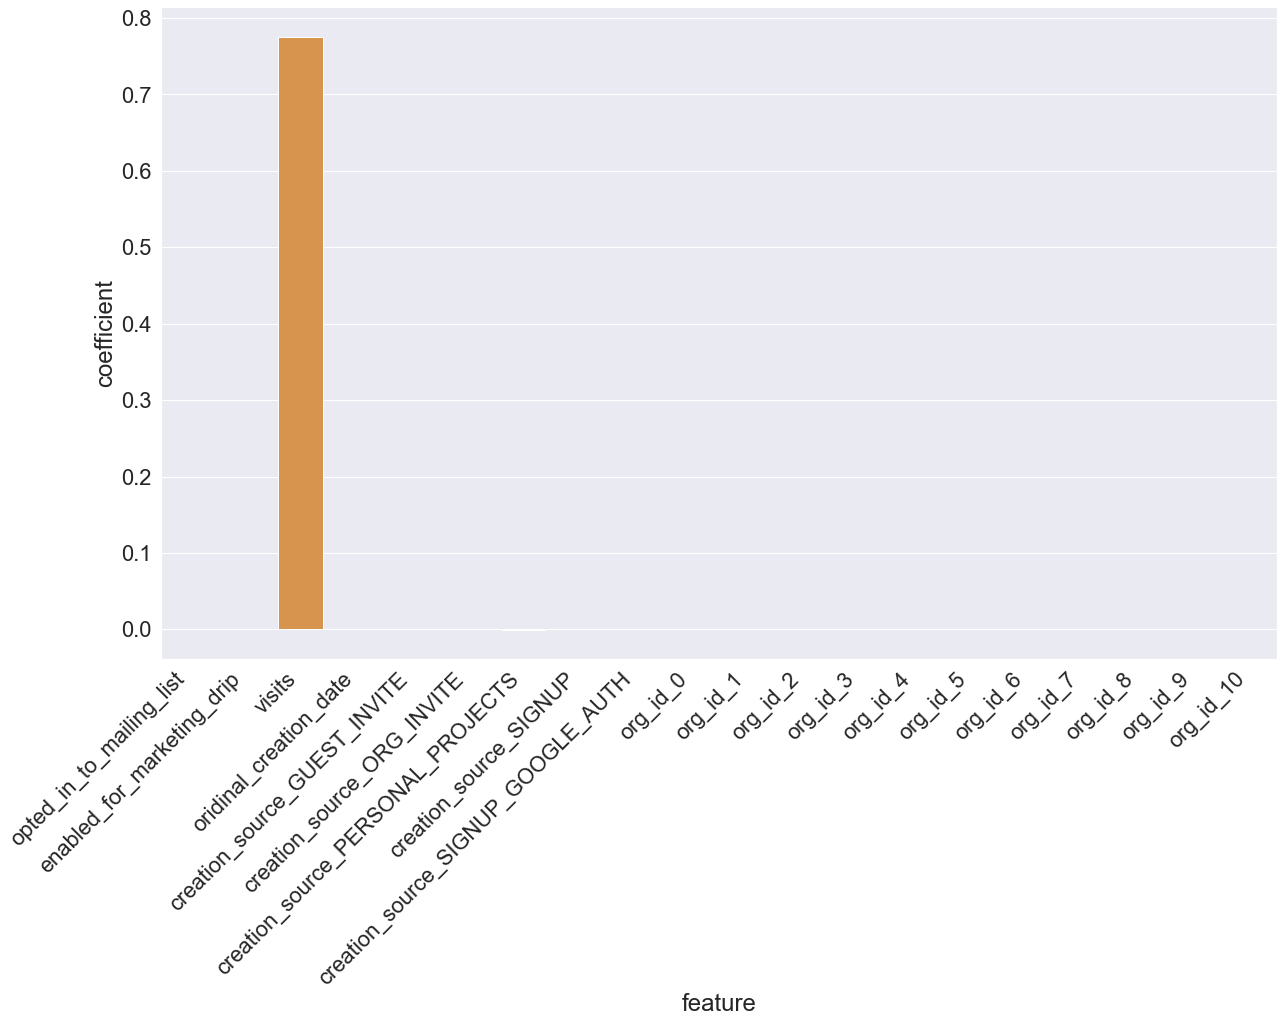

In [177]:
plt.figure(figsize = (20,12))
ax = sns.barplot(x='feature',y='coefficient', data=coef_df.head(20))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45, ha='right')
sns.set(font_scale = 2)
plt.show()